In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt
import os
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import tensorflow as tf
import graphviz
import pydot
import sys
import skimage

In [2]:
import numpy as np
import pandas as pd

In [3]:
sys.path.insert(0, '..')
from function import create_new_folder

In [4]:
#generate a dataset
image_path = r'..\images'

In [5]:
df = pd.read_csv(r'..\data\sample.csv')
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [7]:
list(df.label.unique())

['Impressionism', 'Post-Impressionism', 'Northern Renaissance']

In [8]:
#filter any corrupt data
from PIL import Image

def delete_corrupt_image(image_path):
    num_skipped = 0

    for folder_name in os.listdir(image_path):
        folder_path = os.path.join(image_path, folder_name)
        for fname in os.listdir(folder_path):
            fpath = os.path.join(folder_path, fname)
            try:
                img = Image.open(fpath) #open and read images in file path
                img.verify() #verify this is an image
            except(IOError, SyntaxError) as e:
                print(f'Bad file: {fname}')
                num_skipped+=1
                # Delete corrupted image
                os.remove(fpath)

    print(f'Deleted {num_skipped} images')

In [11]:
image_size = (150, 150) #(height, width)
batch_size = 32
num_classes = len(os.listdir(image_path))

from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(rotation_range=40, 
                                   width_shift_range=0.5,
                                   height_shift_range=0.5, 
                                   brightness_range=(0.1, 1.0),
                                   rescale=1./255, 
                                   shear_range=0.5,
                                   zoom_range=0.5,
                                   horizontal_flip=True, 
                                   fill_mode='reflect',  #figure out difference between nearest and reflect
                                   validation_split = 0.2)

train_generator = img_gen.flow_from_directory(directory=image_path, 
                                              target_size=image_size,
                                              classes=list(df.label.unique()),
                                              class_mode='categorical', 
                                              batch_size = batch_size,
                                              subset='training',
                                              shuffle=False,
                                              seed=42)

validation_generator = img_gen.flow_from_directory(directory=image_path, 
                                                   target_size=image_size,
                                                   classes=list(df.label.unique()),
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   subset='validation',
                                                   shuffle=False,
                                                   seed=42)

'''test_generator = img_gen.flow_from_directory(directory=test_path, 
                                                   target_size=image_size,
                                                   classes=list(df.label.unique()),
                                                   class_mode='categorical', 
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   seed=42)'''

Found 1240 images belonging to 3 classes.
Found 308 images belonging to 3 classes.


C:\Users\Justine\anaconda3\envs\deep_learning\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


{'Impressionism': 0, 'Post-Impressionism': 1, 'Northern Renaissance': 2}

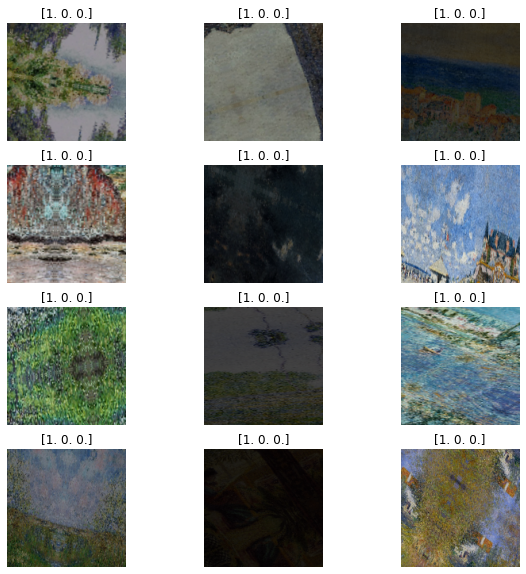

In [10]:
#visualize some of the data
from keras.preprocessing.image import array_to_img, img_to_array, load_img

plt.figure(figsize=(10, 10))

x, y = train_generator.next() 
#x is a numpy array of the img, y is the one-hot encode labels

for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    image = x[i]
    plt.imshow(image)
    plt.title(y[i])
    plt.axis("off")
    
train_generator.class_indices

In [ ]:
#add weights to model

In [16]:
import scipy as sp
import seaborn as sns
import sklearn as sk
import cv2
from keras import layers

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

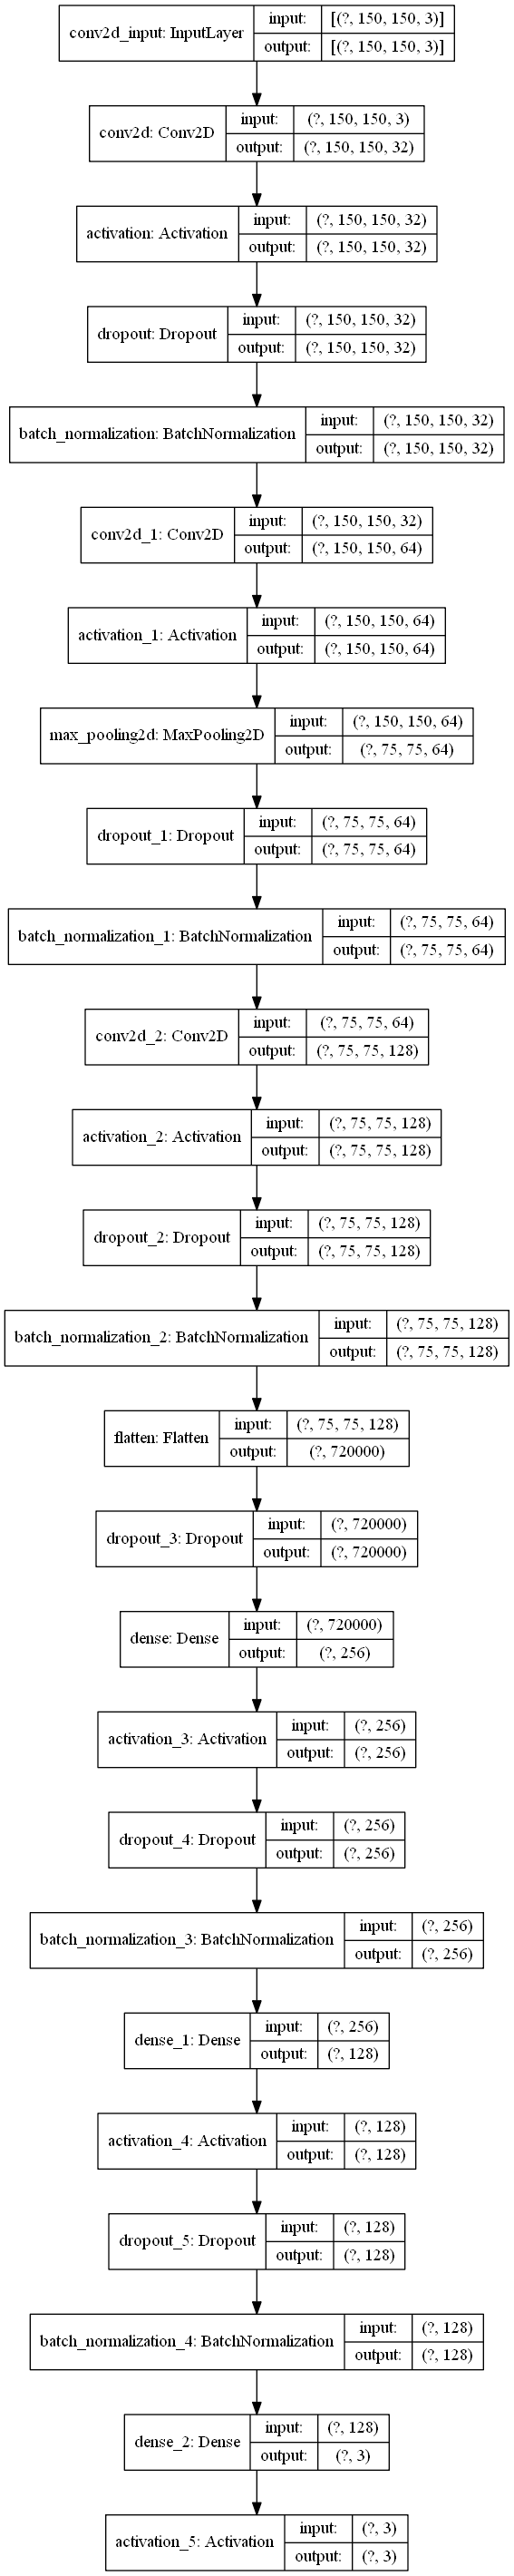

In [20]:
#sequential model for CNN
def sequential_model(input_shape, num_classes):
    #create a dense layer?
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(2)) #Pooling too often will lead to there being almost nothing for the densely connected layers to learn about when the data reaches them.
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    
    model.add(Dense(256, kernel_constraint=maxnorm(3), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(128, kernel_constraint=maxnorm(3), activation='relu'))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = cnn_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [24]:
modelpath = r'../models/model'
epochs = 25

In [110]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_cnn_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy', 'precision', 'recall'],
                 )

model.fit(train_generator,
              epochs=epochs,
              callbacks=callbacks,
              validation_data=validation_generator,)#try train_data, train_labels from train_generator?

print(model.summary())

Epoch 1/15
39/39 [==============================] - 338s 9s/step - loss: 1.4818 - accuracy: 0.3331 - val_loss: 1.0802 - val_accuracy: 0.4448
Epoch 2/15
39/39 [==============================] - 317s 8s/step - loss: 1.2310 - accuracy: 0.3581 - val_loss: 1.0768 - val_accuracy: 0.4448
Epoch 3/15
39/39 [==============================] - 322s 8s/step - loss: 1.2104 - accuracy: 0.3782 - val_loss: 1.0925 - val_accuracy: 0.4448
Epoch 4/15
39/39 [==============================] - 307s 8s/step - loss: 1.1686 - accuracy: 0.3806 - val_loss: 1.0753 - val_accuracy: 0.4448
Epoch 5/15
39/39 [==============================] - 312s 8s/step - loss: 1.1559 - accuracy: 0.3774 - val_loss: 1.0822 - val_accuracy: 0.4448
Epoch 6/15
39/39 [==============================] - 287s 7s/step - loss: 1.1468 - accuracy: 0.3879 - val_loss: 1.0781 - val_accuracy: 0.4448
Epoch 7/15
39/39 [==============================] - 289s 7s/step - loss: 1.1374 - accuracy: 0.3847 - val_loss: 1.0697 - val_accuracy: 0.4448
Epoch 8/15
39

In [25]:
reconstructed_model = keras.models.load_model(os.path.join(modelpath,f'model_cnn_checkpoint_{epochs}.h5'))

In [26]:
model = reconstructed_model

In [52]:
x_val, y_val = validation_generator.next()
#generate_score_array(x_val)

In [56]:
#img = keras.preprocessing.image.load_img(
    r'../raw_images/Georges_Seurat/Georges_Seurat_6.jpg', target_size=image_size
)
#img_array = keras.preprocessing.image.img_to_array(img)
#img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict_generator(test_generator)
score = predictions[0]

print(f'This image is {score[0]*100}% Impressionism, {score[1]*100}% Post-Impressionism, and {score[2]*100}% Northern Rennaisance')

This image is 0.0% Impressionism, 100.0% Post-Impressionism, and 3.2535485663211886e-25% Northern Rennaisance


In [50]:
predictions

array([[0.0000000e+00, 1.0000000e+00, 3.2535486e-27]], dtype=float32)

In [44]:
'''def generate_score_array(img_array):
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]'''    

4800


In [ ]:
#matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

In [ ]:
'# Model evaluation
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))'''

In [13]:
test1 = '../models/model'
create_new_folder(test1)

../models/model path already exists


In [ ]:
#resnet
#with pre-trained weights; see https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [ ]:
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), #how is this diff from Adam
              metrics=['accuracy'])

'''
Here are a few more approaches you can try to get to above 0.95:

more aggresive data augmentation
more aggressive dropout
use of L1 and L2 regularization (also known as "weight decay")
fine-tuning one more convolutional block (alongside greater regularization)'''

In [ ]:
#RESNET50
def identity_block(x, f, filters, stage, block):
    '''
    Identity Block for ResNet
    
    Arguments:
    x - input tensor of shape (x, y, z, w)
    f - int, specifies shape of middle Conv2D layer
    filters - list of ints; number of filters for each CONV layer in the main path
    stage - int, used to name layers by position in network
    block - str, used to name layers by position in network
    
    Returns:
    x - output of identity block with shape (x1, y1, z1, w1)
    
    '''
    
    #define names
    conv_name = f'res{stage}{block}'
    bn_name = f'bn{stage}{block}'
    
    #extract filters from list
    f1, f2, f3 = filters
    
    #save input value to add back to main path
    x_input = x
    
    #First block of main path
    x = layers.Conv2D(f1, kernel_size=1, strides=1, padding='valid', name=conv_name+'2a')(x)
    x = layers.BatchNormalization(name=bn_name+'2a')(x)
    x = layers.Activation('relu')(x)
    
    #Second block of main path
    x = layers.Conv2D(f2, kernel_size=f, strides=1, padding='same', name=conv_name+'2b')(x)
    x = layers.BatchNormalization(name=bn_name+'2b')(x)
    x = layers.Activation('relu')(x)
    
    #Third block of main path
    x = layers.Conv2D(f3, kernel_size=1, strides=1, padding='valid', name=conv_name+'2c')(x)
    x = layers.BatchNormalization(name=bn_name+'2c')(x)
    
    #input added back to main path and passed through a RELU activation
    x = layers.Add()[x, x_input])
    x = layers.Activation('relu')(x)
    
    return x

In [ ]:
def convolutional_block(x, f, filters, stage, block):
    '''
    Convolutional Block for ResNet
    
    Arguments:
    x - input tensor of shape (x, y, z, w)
    f - int, specifies shape of middle Conv2D layer
    filters - list of ints; number of filters for each CONV layer in the main path
    stage - int, used to name layers by position in network
    block - str, used to name layers by position in network
    
    Returns:
    x - output of identity block with shape (x1, y1, z1, w1)
    
    '''
    
    #define names
    conv_name = f'res{stage}{block}'
    bn_name = f'bn{stage}{block}'
    
    #extract filters from list
    f1, f2, f3 = filters
    
    #save input value to add back to main path
    x_input = x
    
    #First block of main path
    x = layers.Conv2D(f1, kernel_size=1, strides=1, name=conv_name+'2a')(x)
    x = layers.BatchNormalization(name=bn_name+'2a')(x)
    x = layers.Activation('relu')(x)
    
    #Second block of main path
    x = layers.Conv2D(f2, kernel_size=f, strides=1, padding='same', name=conv_name+'2b')(x)
    x = layers.BatchNormalization(name=bn_name+'2b')(x)
    x = layers.Activation('relu')(x)
    
    #Third block of main path
    x = layers.Conv2D(f3, kernel_size=1, strides=1, padding='valid', name=conv_name+'2c')(x)
    x = layers.BatchNormalization(name=bn_name+'2c')(x)
    
    #skip connection path
    x = layers.Conv2D(f3, kernel_size=1, strides=1, padding='valid', name=conv_name+'1')(x_input)
    x = layers.BatchNormalization(name=bn_name+'1')(x_input)
    
    #input added back to main path and passed through a RELU activation
    x = layers.Add()[x, x_input])
    x = layers.Activation('relu')(x)
    
    return x

In [ ]:
def resnet50_model(input_shape, num_classes):
    '''
    Implements ResNet50 with the following architecture:
    
    Conv2D -> BatchNormalization -> ReLu -> MaxPool -> Conv2D -> IDBlock*2 
    -> ConvBlock -> IDBlock*3 -> ConvBlock -> IDBlock*5 -> ConvBlock 
    -> IDBlock*2 -> AvgPool -> FCDenseLayer
    
    Arguments:
    input_shape - shape of images in the dataset
    classes - int, number of total classes
    
    Returns:
    model - returns a Keras model
    '''
    
    #Define the input with shape input_shape
    x_input = keras.Input(shape=input_shape)
    
    #Zero-padding
    x = ZeroPadding2D(3)(x_input)
    
    #First Stage
    x = Conv2D(32, kernel_size=5, strides=2, name='conv1')(x)
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2)(x)
    
    #Second Stage
    x = convolutional_block(x, f=3 filters=[32, 32, 64], stage=2, block='a')
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='b')
    x = identity_block(x, 3, [32, 32, 64], stage=2, block='c')
    
    #Third Stage
    x = convolutional_block(x, f=3 filters=[64, 64, 256], stage=3, block='a')
    x = identity_block(x, 3, [64, 64, 256], stage=3, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=3, block='c')
    x = identity_block(x, 3, [64, 64, 256], stage=3, block='d')
    
    #Fourth Stage
    x = convolutional_block(x, f=3 filters=[128, 128, 512], stage=4, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='d')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='e')
    x = identity_block(x, 3, [128, 128, 512], stage=4, block='f')
    
    #Fifth Stage
    x = convolutional_block(x, f=3 filters=[256, 256, 1024], stage=5, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=5, block='c')
    
    #output layer
    x = AveragePooling2D(2, name='avg_pool')(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation='softmax', name=f'fc{num_classes}')
    
    model = Model(inputs=x_input, outputs=X, name='ResNet50')
        
    return model

In [ ]:
model = resnet50_model(input_shape=img_size+(3,), num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(os.path.join(modelpath,f'model_resnet50_checkpoint_{epochs}.h5')),]

model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy', 'precision', 'recall'],
                 )

model.fit(train_generator,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=validation_generator,
          batch_size=batch_size)#try train_data, train_labels from train_generator?

print(model.summary())

Notes: create a test folder to evaluate; maybe use a completely independent data set? or just take a chunk out from raw images
Lessons learned:
how can we increase weights for paintings that are not as recognizable or as well known; for example other cultures - my data set only focuses on european art work - how to make this more inclusive